In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import time

In [46]:
class SMABacktester:
    def __init__(self, symbol, sma_s, sma_l, start, end):
        '''
        Param:
        _______
            symbol:str , ticker symbol(instrutment) you want to backtest
            sma_s:str moving window in bars for shorted sma
            sma_l :str mobing window in bars for longer sma
            start and end :
                both:str start/end date for import the data 
        '''
        self.symbol = symbol
        self.sma_s = sma_s
        self.sma_l = sma_l
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
        self.prepare_data()
    def __repr__(self):
        return "SMABacktester(symbol = {} ,sma_s = {} , sma_l = {} , start = {} , end = {}".format(self.symbol,self.sma_s,self.sma_l,self.start,self.end)
    def get_data(self):
        raw = pd.read_csv("pair_trade.csv", parse_dates=["Date"], index_col="Date")
        print("raw copyed")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        print(raw)
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw["price"] / raw["price"].shift(1))  # calculate the log return
        self.data = raw
        return raw
    def prepare_data(self):
        data = self.data.copy()
        data["sma_s"] = data["price"].rolling(self.sma_s).mean()
        data["sma_l"] = data["price"].rolling(self.sma_l).mean()
        self.data = data
    def set_parameters(self,sma_s = None,sma_l = None):
        if sma_s is not None:
            self.sma_s = sma_s
            self.data["sma_s"]=self.data["price"].rolling(self.sma_s).mean()
        if sma_l is not None:
            self.sma_l = sma_l
            self.data["sma_l"] = self.data["price"].rolling(self.sma_l).mean()
    def test_strategy(self):
        data = self.data.copy().dropna()
        data["position"] = np.where(data["sma_s"] > data["sma_l"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp) 
        self.results = data
        strategy_perf = data["cstrategy"].iloc[-1]
        buy_and_hold_perf = data["creturns"].iloc[-1]
        outperf = strategy_perf - buy_and_hold_perf
        # print(f"Buy-and-Hold Return: {round(buy_and_hold_perf, 6)}")
        # print(f"Strategy Return: {round(strategy_perf, 6)}")
        # print(f"Outperformance: {round(outperf, 6)}")
        return round(strategy_perf, 6), round(outperf, 6)
    def plot_results(self):
        if self.results is None:
            self.test_strategy();
        title = "{} | SMA_s = {} |SMA_l = {}".format(self.symbol,self.sma_s,self.sma_l)
        self.results[["creturns","cstrategy"]].plot(title = title,figsize = (12,8))
    def optimize_parameters(self, sma_s_range, sma_l_range):
        start_time = time.time()
        combinations = list(product(range(*sma_s_range), range(*sma_l_range)))
        ans = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            ans.append(self.test_strategy()[0])
        best_perf = np.max(ans)
        opt = combinations[np.argmax(ans)]
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
        many_ans = pd.DataFrame(data=combinations, columns=["sma_s", "sma_l"])
        many_ans["performance"] = ans
        end_time = time.time()
        print("function took {} sc to compute the best range".format(end_time - start_time));
        return opt, best_perf

In [44]:
tester = SMABacktester("AUDEUR=X",50,200,"2019-01-01","2023-06-30")

raw copyed
            AUDEUR=X
Date                
2019-01-01   0.61252
2019-01-02   0.61485
2019-01-03   0.61060
2019-01-04   0.61500
2019-01-07   0.62426
...              ...
2023-06-26   0.61245
2023-06-27   0.61171
2023-06-28   0.60974
2023-06-29   0.60460
2023-06-30   0.60903

[1174 rows x 1 columns]


In [45]:
tester.optimize_parameters((10,50,1),(100,252,1))

function took 26.74100613594055 time to compute the best range


((31, 168), 1.130199)

In [31]:
tester.test_strategy()

Buy-and-Hold Return: 0.995635
Strategy Return: 1.130199
Outperformance: 0.134564


(1.130199, 0.134564)

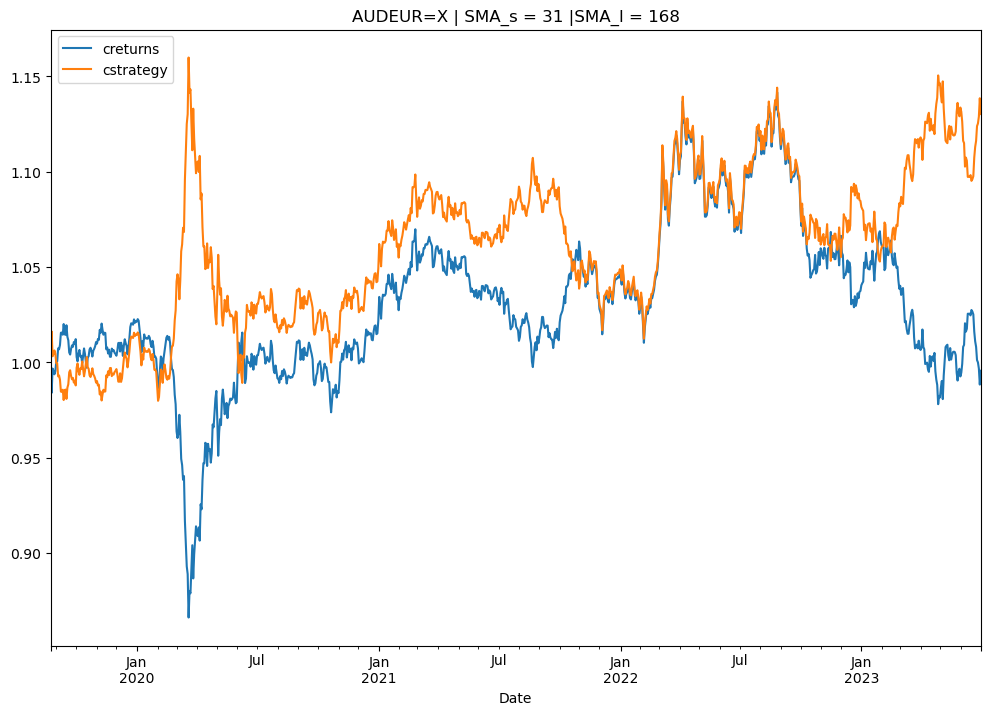

In [14]:
t

(1.130199, 0.134564)

In [8]:
tester.sma_s

5

In [9]:
tester.data.isna().sum()

price       0
returns     1
sma_s       4
sma_l      59
dtype: int64

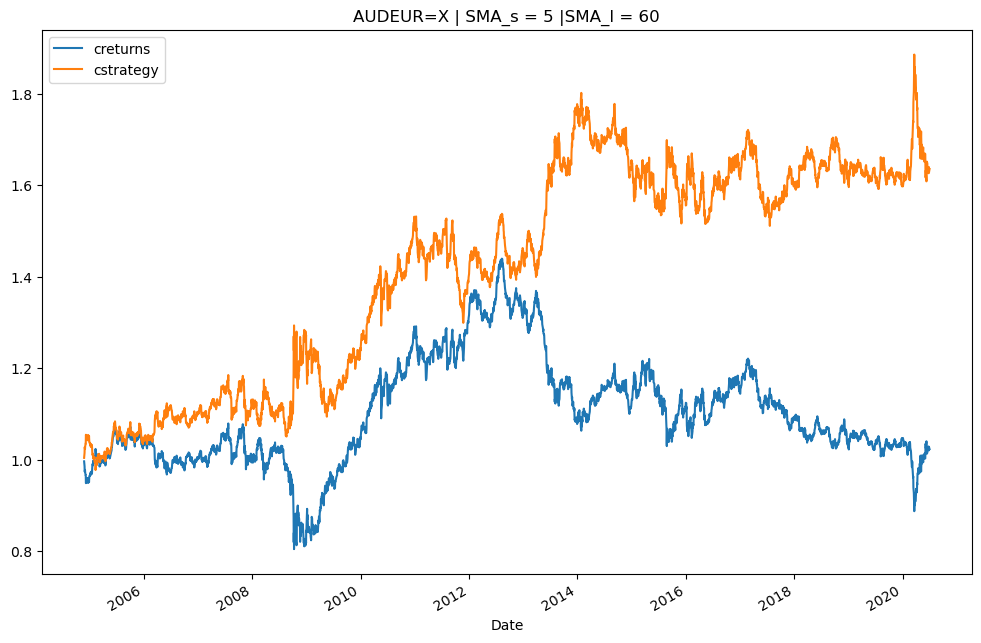

In [10]:
tester.plot_results()